In [1]:
"""

Testing synaptic depression and facilitation.


"""

'\n\nTesting synaptic depression and facilitation.\n\n\n'

In [2]:
import sys
sys.path.append("..//")

from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *

#from AQUAmeetBrian import AQUAMeetBrian


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brian2 import *

#### Synaptic Depression

WARNING    'C' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.03. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'k' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't_a1' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 4.9. The internal variable will be

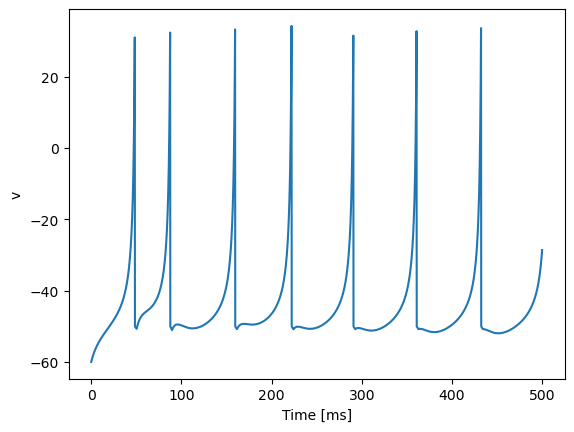

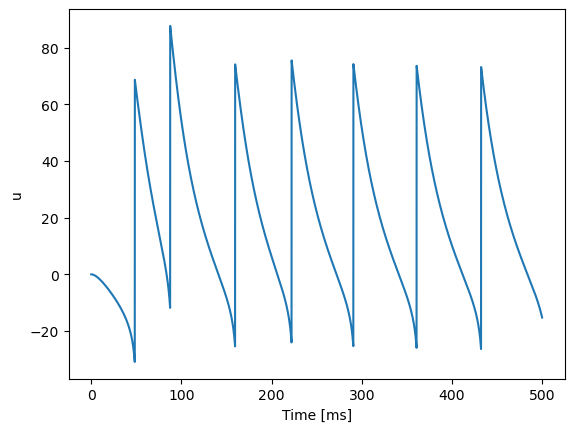

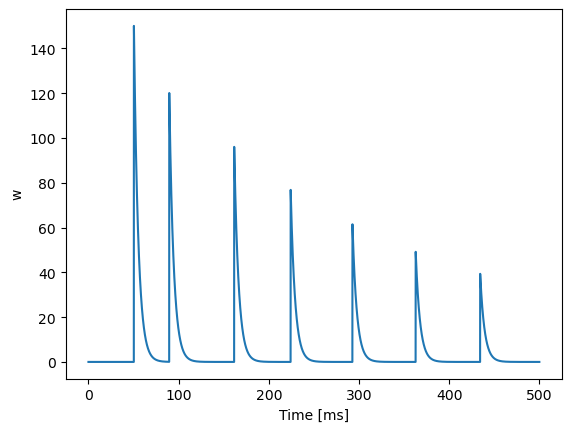

Spike times: [ 48.3  87.5 159.5 222.1 290.6 360.7 432.2] ms


In [3]:
"""AQUA

Normal AQUA autapse but with synaptic depression

"""

start_scope()

RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 't_a1': 4.9, 't_a2': 5., 'f': 150., 'tau': 2.0}    # Class 1

C = RS['C']
k = RS['k']
v_r = RS['v_r']
v_t = RS['v_t']
a = RS['a']
b = RS['b']
c = RS['c']
d = RS['d']
v_peak = RS['v_peak']
# autapse
t_a1 = RS["t_a1"]
t_a2 = RS["t_a2"]
f = RS['f']
tau = RS['tau']*ms

## The autapse could be implemented through a time-delayed synapse, or somehow the reset can be delayed manually...
eqs = f'''
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
du/dt = (a * (b*(v-v_r) - u))/ms : 1
dw/dt = ((t_a2 / t_a1) ** (t_a1 / (t_a2 - t_a1))*x-w)/t_a1/ms : 1
dx/dt = -x/t_a2/ms : 1
C : 1
k : 1
v_r : 1
v_t : 1
I : 1
a : 1
b : 1
c : 1
d : 1
f : 1
m : 1
t_a1 : 1
t_a2 : 1
tau : 1
'''


reset = '''
v = c
u += d
'''

G = NeuronGroup(1, eqs, threshold= 'v>=v_peak', reset = reset, method = 'euler')
M_v = StateMonitor(G, 'v', record = 0)
M_u = StateMonitor(G, 'u', record = 0)
M_w = StateMonitor(G, 'w', record = 0)
spikemon = SpikeMonitor(G, record = True)

# synaptic depression recovery rate, in ms
tau_rec = 100
# Synapses
autapse = '''
dw/dt = ((t_a2 / t_a1) ** (t_a1 / (t_a2 - t_a1))*x-w)/t_a1/ms : 1
dx/dt = -x/t_a2/ms : 1
dm/dt = (1-m)/tau_rec : 1 (event-driven)
m : 1
f : 1
t_a1 : 1
t_a2 : 1
tau : 1
tau_rec : 1
'''
aut = Synapses(G, G,  
             on_pre='''
             w += f * m
             m -= m * 0.2
             ''')
aut.connect(condition = 'i == j')
aut.delay = tau
aut.m = 1.0


# Intialise variables
G.v = -60
G.C = C
G.k = k
G.v_r = v_r
G.v_t = v_t
G.a = a
G.b = b
G.I = 100        # the driving current is static in this case
G.c = c
G.d = d
G.t_a1 = t_a1
G.t_a2 = t_a2
G.f = f


duration = 500*ms
run(duration)


plot(M_v.t/ms, M_v.v[0])
xlabel('Time [ms]')
ylabel('v')
show()

plot(M_u.t/ms, M_u.u[0])
xlabel('Time [ms]')
ylabel('u')
show()

plot(M_w.t/ms, M_w.w[0])
xlabel('Time [ms]')
ylabel('w')
show()

print(f"Spike times: {spikemon.t[:]}")